# 1. Import Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
from numpy import asarray
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy
import folium
import json
import requests
from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans 
import pylab as pl 
import quandl
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

# 2. Import Data

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'yourAPIkey'

In [3]:
path = r'/Users/golde/Crime Analysis/'

In [4]:
crimes = pd.read_csv(os.path.join(path, '2. Data','Prepared Data', 'crimes_w_dates.csv'))

In [5]:
pd.options.display.max_columns = None

In [6]:
crimes = crimes.drop(columns = ['Unnamed: 0'])

In [ ]:
crimes.head()

In [ ]:
crimes.sort_values(by='Date')

# 3. Data Wrangling

In [7]:
#Create subset
df = crimes[['Date','Community Area']]

In [8]:
df = df.reset_index(drop=True)

In [9]:
df

,Date,Community Area
0,2015-09-05 13:30:00,61.0
1,2015-09-04 11:30:00,25.0
2,2015-09-05 12:45:00,21.0
3,2015-09-05 13:00:00,25.0
4,2015-09-05 10:55:00,71.0
...,...,...
1015296,2019-10-24 11:45:00,69.0
1015297,2001-01-03 06:00:00,25.0
1015298,2019-01-29 19:00:00,25.0
1015299,2019-10-24 06:36:00,42.0


In [10]:
data_sub = df.loc[(df['Date'] >= '2001-01-01') & (df['Date'] <= '2020-12-13')]

In [11]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Community Area
datetime,
2015-09-05 13:30:00,61.0
2015-09-04 11:30:00,25.0
2015-09-05 12:45:00,21.0
2015-09-05 13:00:00,25.0
2015-09-05 10:55:00,71.0


In [12]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

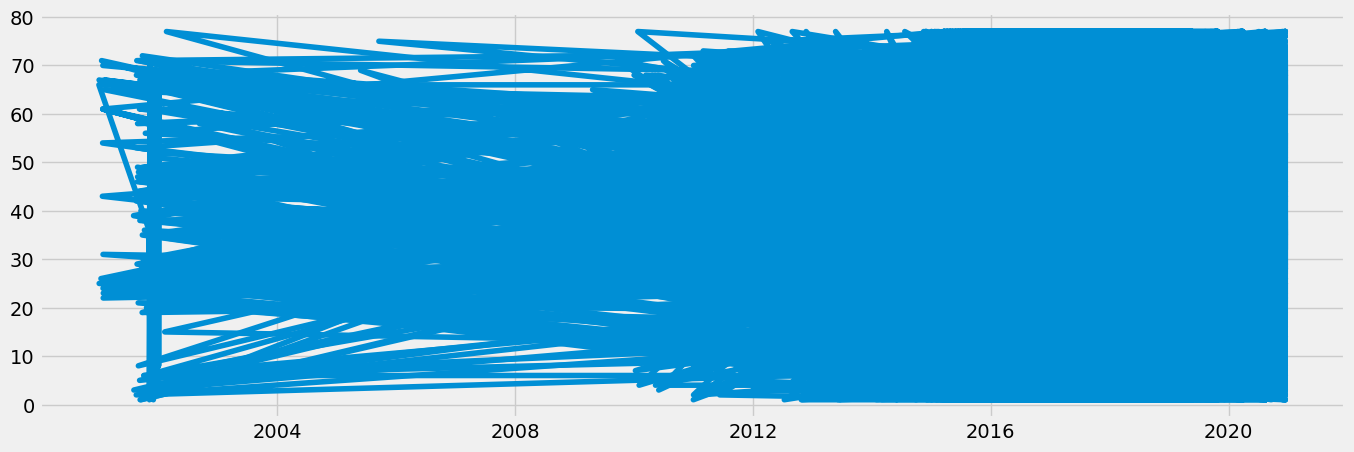

In [13]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [14]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Community Area    0
dtype: int64

In [15]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

1014795

# 4. Time-Series Analysis: Decomposition

In [16]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period = int(len(data_sub)/2))

In [17]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

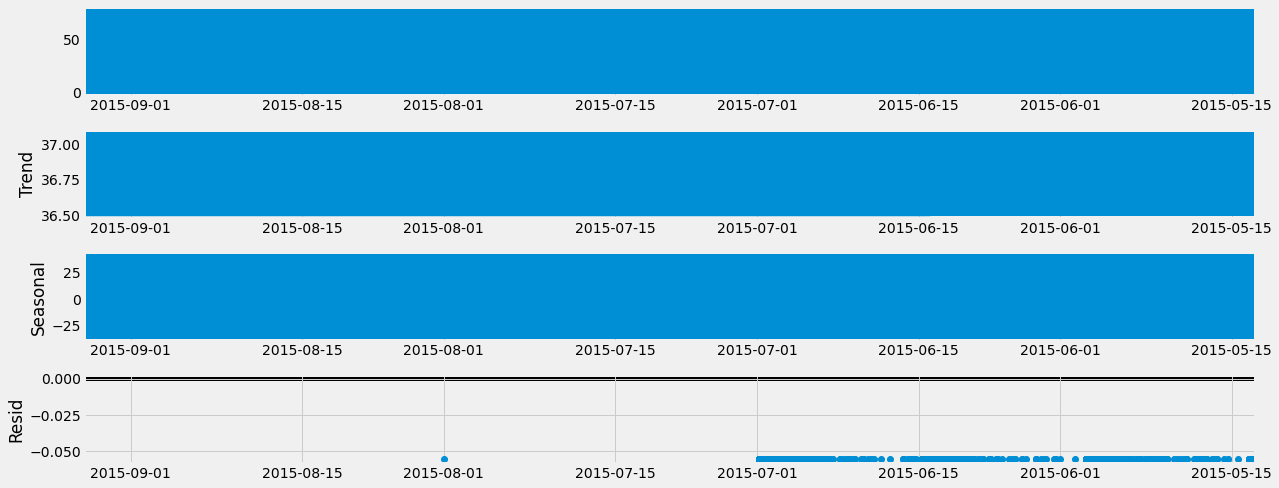

In [18]:
# Plot the separate components

decomposition.plot()
plt.show()

# 5. Testing for stationarity

In [19]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Community Area'])

Dickey-Fuller Stationarity test:


KeyboardInterrupt: 

In [ ]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# 6. Stationarizing the Federal Reserve Economic Data

In [ ]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [ ]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [ ]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [ ]:
dickey_fuller(data_diff)

In [ ]:
plot_acf(data_diff)
plt.show()